## Imports

In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import mne
from scipy.integrate import trapezoid
import pandas as pd

## Defining Important Features

In [87]:
DATASET_PATH = '../COGS 118C Project/data/'  # Update if needed
SUBJECTS = ["S001", "S002", "S003", "S004", "S005"]  

REAL_MOVEMENT_RUNS = ["R03", "R04", "R07"]  
IMAGINED_MOVEMENT_RUNS = ["R08", "R11", "R12"]  

PROCESSED_CHANNELS = ['C3..', 'Cz..', 'C4..']  

SFREQ = 160  
LOW_CUT = 1  
HIGH_CUT = 40  
NOTCH_FREQ = 60  

bands = {
    'theta': (4, 7),
    'alpha': (8, 13),
    'beta': (14, 30),
    'gamma': (30, 40)
}

## Processing

In [88]:
results = {
    'real_movement': {'raw': {}, 'processed': {}},
    'imagined_movement': {'raw': {}, 'processed': {}}
}

In [89]:
for subject in SUBJECTS:
    print(f"Processing subject {subject}...")

    for movement_type, runs in zip(['real_movement', 'imagined_movement'], 
                                   [REAL_MOVEMENT_RUNS, IMAGINED_MOVEMENT_RUNS]):
        for run in runs:
            edf_file = os.path.join(DATASET_PATH, subject, f"{subject}{run}.edf")

            try:
                raw = mne.io.read_raw_edf(edf_file, preload=True)
                raw.pick(PROCESSED_CHANNELS)  
                
                results[movement_type]['raw'].setdefault(subject, {})[run] = {
                    ch: raw.get_data(picks=[ch])[0] for ch in PROCESSED_CHANNELS
                }
                
                raw.notch_filter(NOTCH_FREQ, fir_design='firwin')
                raw.filter(l_freq=LOW_CUT, h_freq=HIGH_CUT, method='fir', fir_design='firwin')

                processed_data = {ch: {} for ch in PROCESSED_CHANNELS}
                
                for ch in PROCESSED_CHANNELS:
                    signal = raw.get_data(picks=[ch])[0]
                    freqs, psd = welch(signal, fs=SFREQ, nperseg=min(len(signal) // 2, 128))

                    for band_name, (fmin, fmax) in bands.items():
                        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
                        processed_data[ch][band_name] = trapezoid(psd[idx], freqs[idx]) if np.any(idx) else 0.0
                    
                    processed_data[ch]['freqs'] = freqs
                    processed_data[ch]['psd'] = psd
                
                results[movement_type]['processed'].setdefault(subject, {})[run] = processed_data
            
            except Exception as e:
                print(f"Error processing {subject} {run}: {e}")

Processing subject S001...
Extracting EDF parameters from /Users/ananyakrishnan/Downloads/COGS 118C Project/data/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase,

### Structuring into dataframe

In [90]:
rows = []

for movement_type in ['real_movement', 'imagined_movement']:
    for subject, runs in results[movement_type]['processed'].items():
        for run, channels in runs.items():
            for ch, features in channels.items():
                row = {
                    'movement_type': movement_type.replace('_movement', ''),
                    'subject': subject,
                    'run': run,
                    'channel': ch
                }
                row.update({band: features[band] for band in bands.keys()})
                rows.append(row)

df = pd.DataFrame(rows)
df.to_csv('processed_band_powers.csv', index=False)

## Visualizations

In [102]:
def plot_psd(subject='S001', channel='C3..'):
    """Plot PSD for real and imagined movement"""
    plt.figure(figsize=(10, 5))
    
    for movement_type, label, color in zip(
        ['real_movement', 'imagined_movement'], 
        ['Real Movement', 'Imagined Movement'], 
        ['blue', 'red']
    ):
        for run in results[movement_type]['processed'][subject]:
            if channel in results[movement_type]['processed'][subject][run]:
                data = results[movement_type]['processed'][subject][run]
                freqs, psd = data[channel]['freqs'], data[channel]['psd']
                plt.plot(freqs, psd, label=label, color=color)
                print(f"Plotting {movement_type} for {subject} {run} {channel}")
                break  
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (µV²/Hz)")
    plt.title(f"Power Spectral Density - {subject} {channel}")
    plt.legend()
    plt.grid(True)
    plt.xlim(LOW_CUT, HIGH_CUT)
    plt.savefig(f'psd_{subject}_{channel}.png', dpi=300)
    plt.show()


def plot_psd_per_pair(subject='S001', channel='C3..'):
    """Plot PSD separately for each real-imagined movement pair."""
    
    run_pairs = {
        "R03": "R08",
        "R04": "R11",
        "R07": "R12"
    }
    
    fig, axes = plt.subplots(len(run_pairs), 1, figsize=(10, 5 * len(run_pairs)))
    
    for idx, (real_run, imagined_run) in enumerate(run_pairs.items()):
        ax = axes[idx] if len(run_pairs) > 1 else plt.gca()  # Handle single subplot case

        if real_run in results['real_movement']['processed'].get(subject, {}) and \
           imagined_run in results['imagined_movement']['processed'].get(subject, {}):
            
            real_data = results['real_movement']['processed'][subject][real_run]
            imagined_data = results['imagined_movement']['processed'][subject][imagined_run]
            
            if channel in real_data and channel in imagined_data:
                freqs_real, psd_real = real_data[channel]['freqs'], real_data[channel]['psd']
                freqs_imag, psd_imag = imagined_data[channel]['freqs'], imagined_data[channel]['psd']
                
                ax.plot(freqs_real, psd_real, label=f"Real Movement - {real_run}", color='blue')
                ax.plot(freqs_imag, psd_imag, label=f"Imagined Movement - {imagined_run}", color='red')
                
                ax.set_xlabel("Frequency (Hz)")
                ax.set_ylabel("Power (µV²/Hz)")
                ax.set_title(f"Power Spectral Density - {subject} {channel} ({real_run} vs. {imagined_run})")
                ax.legend()
                ax.grid(True)
                ax.set_xlim(LOW_CUT, HIGH_CUT)
    
    plt.tight_layout()
    plt.savefig(f'psd_per_pair_{subject}_{channel}.png', dpi=300)
    plt.show()

def plot_band_powers():
    """Plot band power distributions for real vs imagined movement."""
    avg_band_powers = df.groupby('movement_type')[list(bands.keys())].mean()

    plt.figure(figsize=(10, 5))
    avg_band_powers.T.plot(kind='bar')
    plt.ylabel("Power (µV²/Hz)")
    plt.title("Average Power in EEG Frequency Bands")
    plt.grid(True)
    plt.savefig("band_powers_comparison.png", dpi=300)
    plt.show()

def plot_avg_psd(channel="C3.."):
    """Plot average PSD across all subjects and trials for real vs. imagined movement."""
    
    real_psds, imagined_psds = [], []
    
    for subject in SUBJECTS:
        for run in REAL_MOVEMENT_RUNS:
            if subject in results['real_movement']['processed'] and run in results['real_movement']['processed'][subject]:
                if channel in results['real_movement']['processed'][subject][run]:
                    real_psds.append(results['real_movement']['processed'][subject][run][channel]['psd'])

        for run in IMAGINED_MOVEMENT_RUNS:
            if subject in results['imagined_movement']['processed'] and run in results['imagined_movement']['processed'][subject]:
                if channel in results['imagined_movement']['processed'][subject][run]:
                    imagined_psds.append(results['imagined_movement']['processed'][subject][run][channel]['psd'])
    
    # Convert lists to arrays
    real_psds = np.array(real_psds)
    imagined_psds = np.array(imagined_psds)
    
    # Compute the mean across all subjects and trials
    mean_real_psd = np.mean(real_psds, axis=0)
    mean_imagined_psd = np.mean(imagined_psds, axis=0)
    
    # Get frequency axis (same for all trials)
    freqs = results['real_movement']['processed'][SUBJECTS[0]][REAL_MOVEMENT_RUNS[0]][channel]['freqs']
    
    # Plot the averaged PSDs
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, mean_real_psd, label="Real Movement - Avg", color="blue")
    plt.plot(freqs, mean_imagined_psd, label="Imagined Movement - Avg", color="red")
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (µV²/Hz)")
    plt.title(f"Average PSD Across Subjects & Trials - {channel}")
    plt.legend()
    plt.grid(True)
    plt.xlim(LOW_CUT, HIGH_CUT)
    plt.savefig(f'avg_psd_{channel}.png', dpi=300)
    plt.show()


Plotting real_movement for S001 R03 C3..
Plotting imagined_movement for S001 R08 C3..


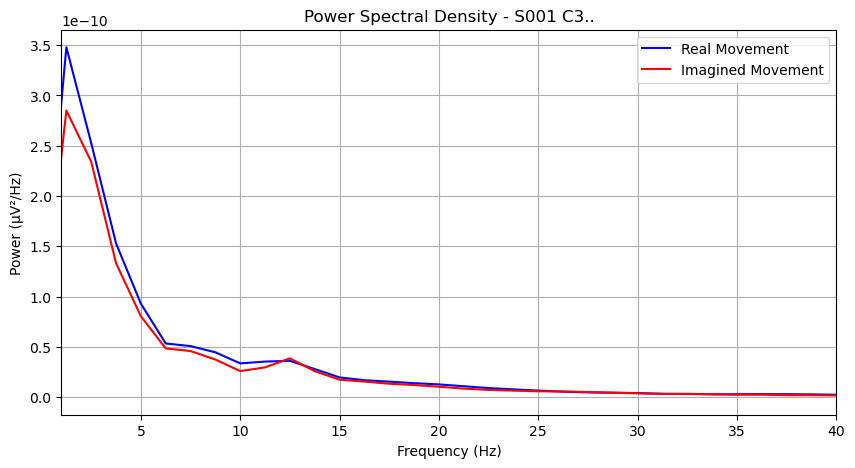

<Figure size 1000x500 with 0 Axes>

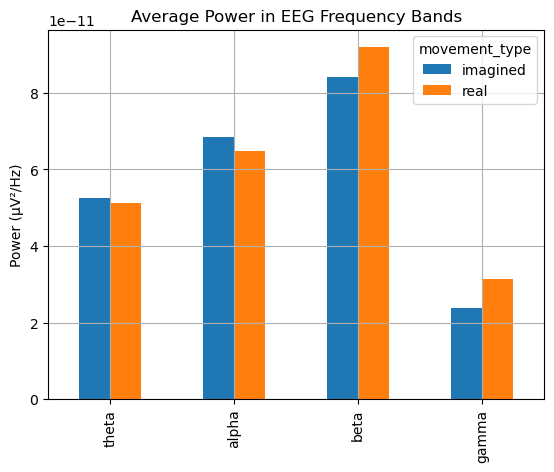

In [103]:
# Plot example PSD
plot_psd(subject="S001", channel="C3..")

# Plot band power distribution
plot_band_powers()

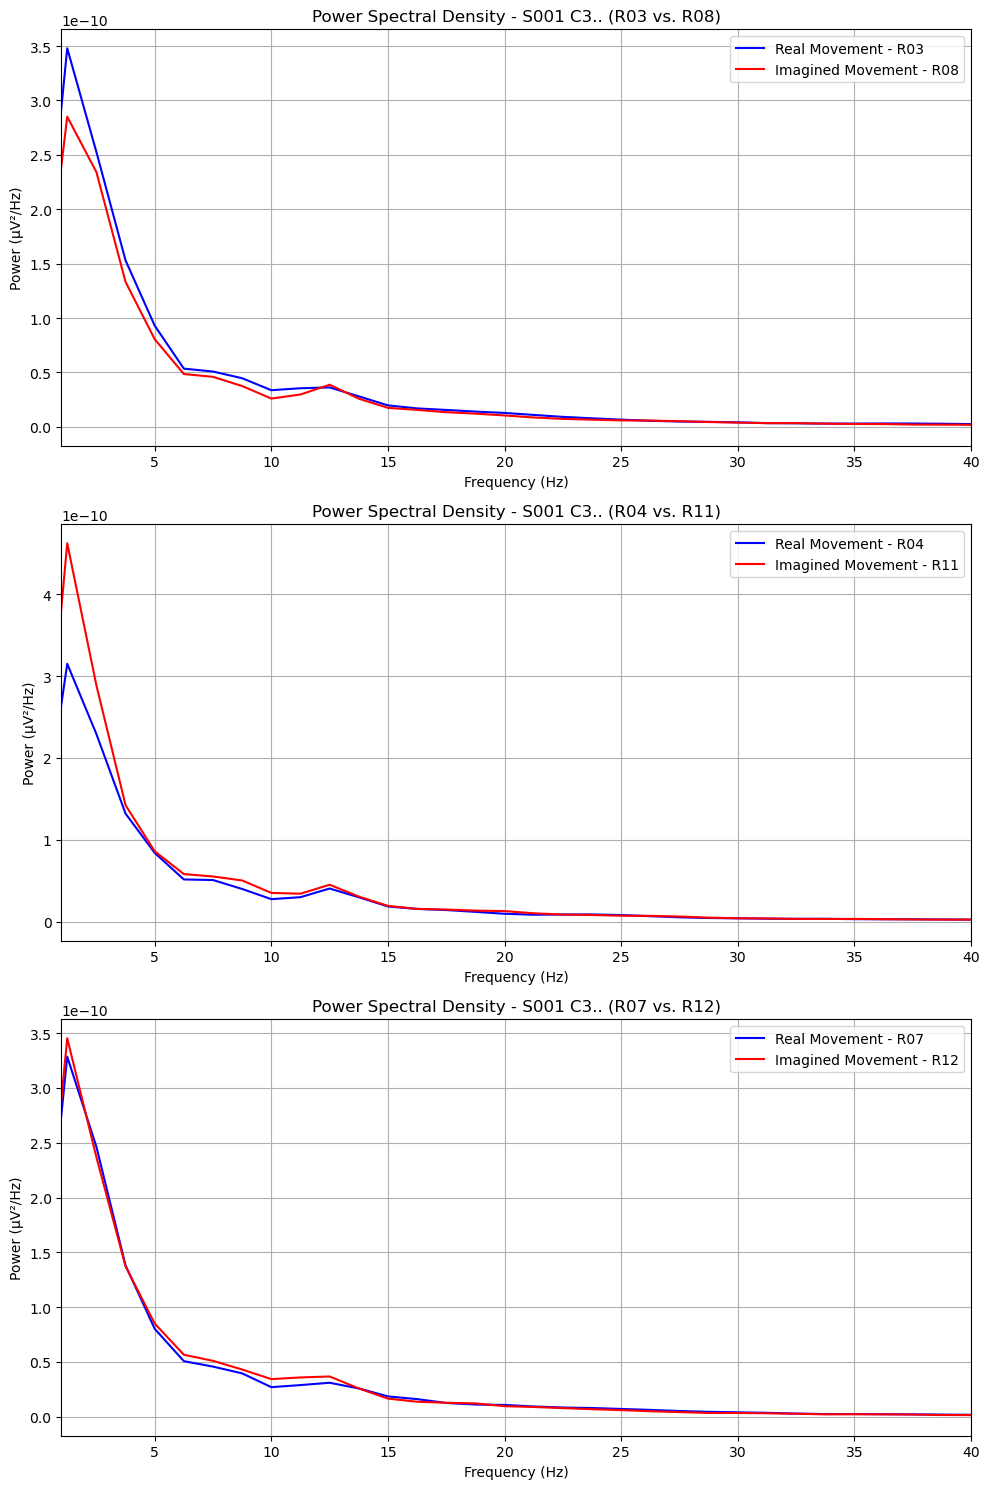

In [104]:
plot_psd_per_pair(subject="S001", channel="C3..")


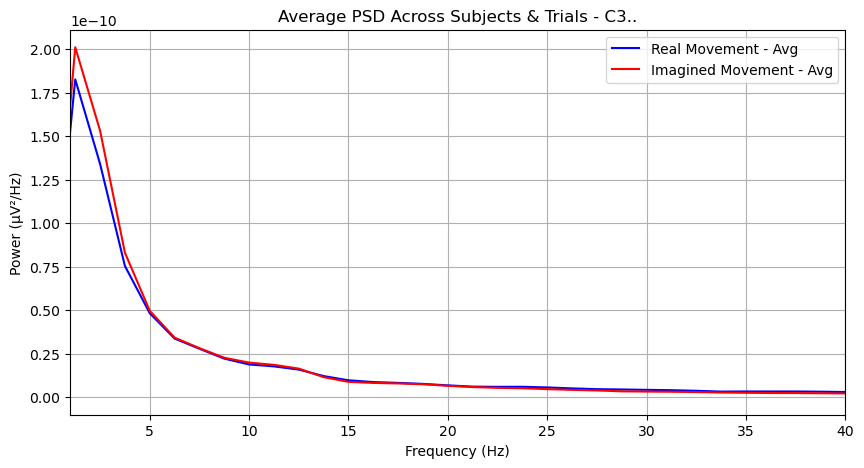

In [105]:
plot_avg_psd()